In [16]:
import os
import sys
import glob
import h5py
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


from copy import copy
from scipy import linalg
from datetime import datetime, timedelta
from mintpy.objects import timeseries
from mintpy.tsview import timeseriesViewer
from mintpy.utils import readfile, utils as ut, plot as pp
from mintpy import view, tsview, plot_network, plot_transection, plot_coherence_matrix

# Inscrese matplotlib font size when plotting
plt.rcParams.update({'font.size': 16})
figsize = 3*np.array([3,4])





def plot_velocitymap(data, pts=None, folder='velocity', title='Velocity', fig_dpi=300,
                     vmin=-20, vmax=20, stdmin=0.0, stdmax=4.0, ampmax=40, plot_seasonalAmp=False, gv=False):
    from matplotlib import colors

    velo_file = f'{folder}/{data}.h5'
    fname = '_'.join([data]+folder.split('_')[1:])
    #fname = '_'.join([data]+[pts]+folder.split('_')[1:])

    # print folder and dataset
    print(f'{folder}/{data}.h5')

    # look for DEM file from ARIA path
    demfile = '../DEM/SRTM_3arcsec.dem'

    # The dataset unit is meter
    v     = readfile.read(velo_file, datasetName='velocity')[0]*1000     # Unit: mm/y
    meta  = readfile.read(velo_file, datasetName='velocity')[1]          # metadata
    try:
        v_std = readfile.read(velo_file, datasetName='velocityStd')[0] *1000  # Unit: mm/y
    except:
        print('No STD for deramp velocity, read the non-deramp velocity STD instead')
        std_file = data.split('_')[0]
        std_file = f'{folder}/{std_file}.h5'
        v_std = readfile.read(std_file, datasetName='velocityStd')[0] *1000  # Unit: mm/y

    if plot_seasonalAmp == True:
        try:
            annualAmp = readfile.read(velo_file, datasetName='annualAmp')[0]*1000                 # Unit: mm
        except:
            print('No seasonal amp for deramp velocity, read the non-deramp velocity seasonal amp instead')
            annualAmp = readfile.read(std_file,  datasetName='annualAmp')[0]*1000  # Unit: mm/y
    else:
        try:
            dem = np.array(readfile.read(demfile)[0], dtype=float)      # Unit: m
        except:
            print('Error: DEM file not found.')


    # read lat/lon info
    try:
        length    = int(meta['LENGTH'])
        width     = int(meta['WIDTH'])
        x_min     = float(meta['X_FIRST'])
        x_step    = float(meta['X_STEP'])
        y_min     = float(meta['Y_FIRST'])
        y_step    = float(meta['Y_STEP'])
        lats      = np.arange(y_min,length*y_step+y_min, y_step)
        lons      = np.arange(x_min, width*x_step+x_min, x_step)
        ref_lat   = float(meta['REF_LAT'])
        ref_lon   = float(meta['REF_LON'])
    except:
        pass

    # read mask and mask the dataset
    mask_file = 'maskTempCoh095.h5'   # 'waterMask.h5' or 'maskTempCoh.h5'
    mask_data = readfile.read(mask_file)[0]
    v[mask_data==0] = np.nan
    v_std[mask_data==0] = np.nan
    if plot_seasonalAmp == True:
        annualAmp[mask_data==0] = np.nan
    else:
        water_mask = readfile.read('waterMask.h5')[0]
        dem[water_mask==0] = np.nan

    if pts is not None:
        # read points file
        pts_file = f'pixels_{pts}.txt'
        file = open(f'{pts_file}','r')
        lines = file.readlines()
        plats = []
        plons = []
        for x in lines:
            tmp = x.split()
            plats.append(float(tmp[0]))
            plons.append(float(tmp[1]))

        # points name
        import string
        alphabet = string.ascii_uppercase
        pix_name = list(alphabet)

    # plot
    font_size=16
    plt.rcParams.update({'font.size': font_size})
    cmap='jet'
    demcmap='terrain'
    nrows, ncols = 1, 3

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=[ncols*8,12])
    divcmap = plt.get_cmap(cmap)
    #divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0., vmax=vmax)
    im0 = ax[0].imshow(v, extent=[lons[0],lons[-1],lats[-1],lats[0]], cmap=divcmap, vmin=vmin, vmax=vmax) #, norm=divnorm)
    im1 = ax[1].imshow(v_std, extent=[lons[0],lons[-1],lats[-1],lats[0]], vmin=stdmin, vmax=stdmax, cmap=cmap)
    if plot_seasonalAmp == True:
        im2 = ax[2].imshow(annualAmp, extent=[lons[0],lons[-1],lats[-1],lats[0]],vmin=0, vmax=ampmax, cmap=cmap)
    else:
        im2 = ax[2].imshow(dem,       extent=[lons[0],lons[-1],lats[-1],lats[0]],vmin=-200, vmax=2000, cmap=demcmap)

    # axis format
    ax[0].set_title(f'{title}')
    first_line = title.split('\n')[0]
    ax[1].set_title(f'Std of {first_line}')
    cbar=fig.colorbar(im0, ax=ax[0], cmap=cmap, extend='both', aspect=50, shrink=0.8, pad=0.01)
    cbar.ax.set_ylabel('mm/year', rotation=270, labelpad=20)
    cbar=fig.colorbar(im1, ax=ax[1], cmap=cmap, extend='both', aspect=50, shrink=0.8, pad=0.01)
    cbar.ax.set_ylabel('mm/year', rotation=270, labelpad=20)

    if plot_seasonalAmp == True:
        ax[2].set_title(f'Absolute annual\namplitude')
        cbar=fig.colorbar(im2, ax=ax[2], cmap=cmap, extend='both', aspect=50, shrink=0.8, pad=0.01)
        cbar.ax.set_ylabel('mm', rotation=270, labelpad=20)
    else:
        ax[2].set_title(f'Topography\n(DEM)')
        cbar=fig.colorbar(im2, ax=ax[2], cmap=demcmap, extend='both', aspect=50, shrink=0.8, pad=0.01)
        cbar.ax.set_ylabel('m', rotation=270, labelpad=20)

    # set scale bar
    sblon = 34.1 # deg, lon location
    sblat = 27 # deg, lat location
    sbr   = 99 # km, distance for 1 longitude deg at sblat
    sblen = 80 # km, total length

    # plot other info
    for j in range(ncols):
        if pts is not None:
            for i in range(len(plats)):
                ax[j].scatter(plons[i], plats[i], s=40, marker='^', c='red', edgecolor='k')
                ax[j].text(plons[i], plats[i], pix_name[i], fontsize=16)
        try:
            ax[j].scatter(ref_lon, ref_lat, marker='s', s=50, c='k')
        except:
            pass
        ax[j].plot(np.array([sblon, sblon+sblen/sbr]), np.array([sblat, sblat]), linewidth=5, c='k')
        ax[j].text(0.5*(sblon+sblon+sblen/sbr), sblat-0.3, f'{sblen} km', ha='center')
        ax[j].set_xlabel('Longitude', fontsize=font_size+4)
        ax[j].set_ylabel('Latitude', fontsize=font_size+4)
        ax[j].set_xlim(34.0,37.5)
        ax[j].set_ylim(26.2,32.5)

    # output
    out_file = f'{pic_dir}/{fname}.png'
    plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
    print('save to file: '+out_file)
    plt.show()

    if gv is True:
        return v, v_std, meta


In [43]:
mask_file = '../../maskTempCoh_high.h5'   # 'waterMask.h5' or 'maskTempCoh.h5'
mask_data = readfile.read(mask_file)[0]

v1   = readfile.read('../velocity1.h5',   datasetName='velocity')[0]*1000     # Unit: mm/y
v2   = readfile.read('../velocity2.h5',   datasetName='velocity')[0]*1000     # Unit: mm/y
vion = readfile.read('../velocityIon.h5', datasetName='velocity')[0]*1000     # Unit: mm/y

vion[mask_data==0] = np.nan
v1[mask_data==0]   = np.nan
v2[mask_data==0]   = np.nan

v = v1 - v2
v2_test = v1 - vion


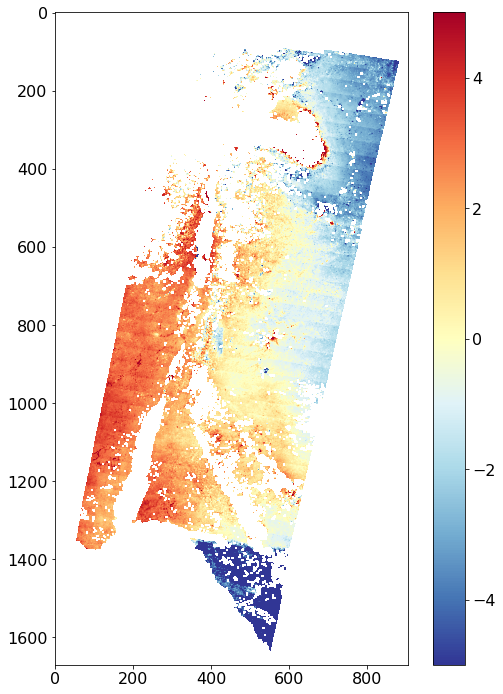

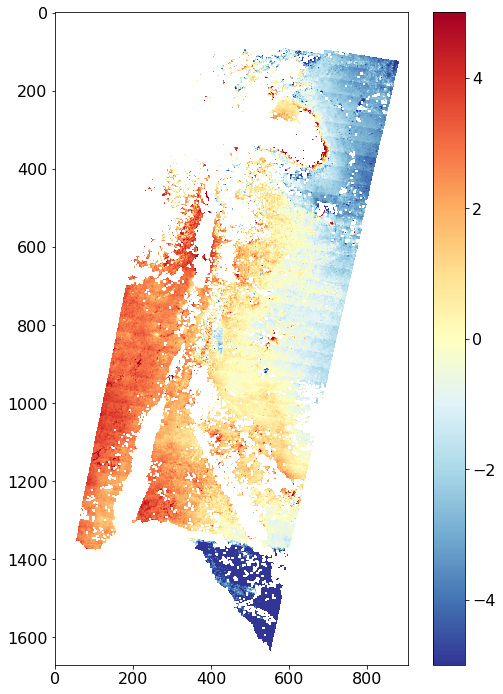

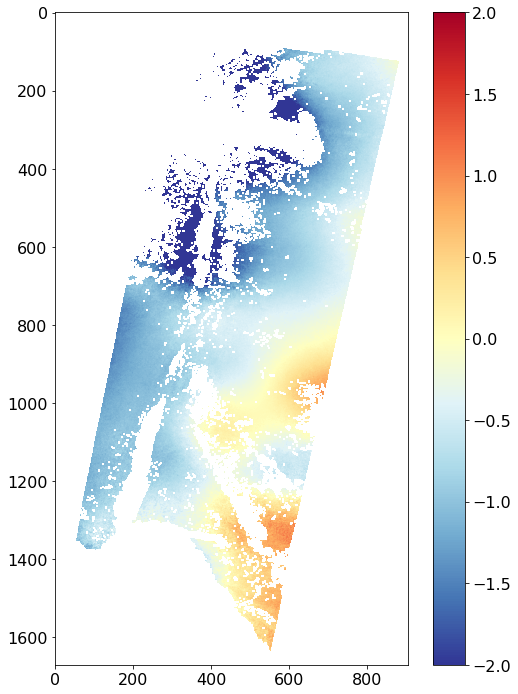

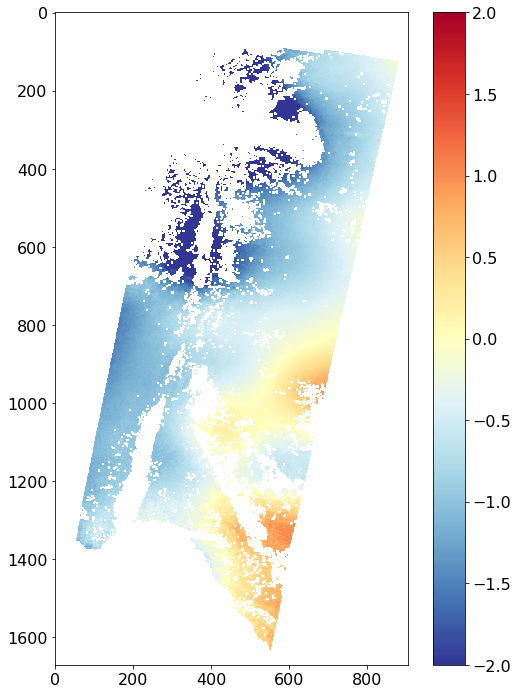

In [44]:
plt.figure(figsize=figsize)
im = plt.imshow(v2, cmap='RdYlBu_r', vmin=-5, vmax=5)
plt.colorbar(im)
plt.show()

plt.figure(figsize=figsize)
im = plt.imshow(v2_test, cmap='RdYlBu_r', vmin=-5, vmax=5)
plt.colorbar(im)
plt.show()

plt.figure(figsize=figsize)
im = plt.imshow(v, cmap='RdYlBu_r', vmin=-2, vmax=2)
plt.colorbar(im)
plt.show()

plt.figure(figsize=figsize)
im = plt.imshow(vion, cmap='RdYlBu_r', vmin=-2, vmax=2)
plt.colorbar(im)
plt.show()